# 3. Продуктовые гипотезы

Нашей командой принято решение также проанализировать 2 продуктовые гипотезы (1 готова, вторая в работе).

GA Sessions
Одна строка = один визит на сайт.
Описание атрибутов:
~ session_id — ID визита;
~ client_id — ID посетителя;
~ visit_date — дата визита;
~ visit_time — время визита;
~ visit_number — порядковый номер визита клиента;
~ utm_source — канал привлечения;
~ utm_medium — тип привлечения;
~ utm_campaign — рекламная кампания;
~ utm_keyword — ключевое слово;
~ device_category — тип устройства;
~ device_os — ОС устройства;
~ device_brand — марка устройства;
~ device_model — модель устройства;
~ device_screen_resolution — разрешение экрана;
~ device_browser — браузер;
~ eo_country — страна;
~ geo_city — город.

GA Hits
Одна строка = одно событие в рамках одного визита на сайт.
Описание атрибутов:
~ session_id — ID визита;
~ hit_date — дата события;
~ hit_time — время события;
~ hit_number — порядковый номер события в рамках сессии;
~ hit_type — тип события;
~ hit_referer — источник события;
~ hit_page_path — страница события;
~ event_category — тип действия;
~ event_action — действие;
~ event_label — тег действия;
~ event_value — значение результата действия.

In [104]:
import pandas as pd
from scipy.stats import mannwhitneyu, chi2_contingency
import numpy as np
import matplotlib.pyplot as plt

In [19]:
gah = pd.read_csv('ga_hits.csv', low_memory=False)
gas = pd.read_csv('ga_sessions.csv', low_memory=False)

In [20]:
# для тестирования возьмём эти действия
target_actions = ['sub_car_claim_click', 'sub_car_claim_submit_click', 'sub_open_dialog_click',
          'sub_custom_question_submit_click', 'sub_call_number_click', 'sub_callback_submit_click',
          'sub_submit_success', 'sub_car_request_submit_click']

In [21]:
gas.isna().sum()

session_id                        0
client_id                         0
visit_date                        0
visit_time                        0
visit_number                      0
utm_source                       97
utm_medium                        0
utm_campaign                 219603
utm_adcontent                335615
utm_keyword                 1082061
device_category                   0
device_os                   1070138
device_brand                 367178
device_model                1843704
device_screen_resolution          0
device_browser                    0
geo_country                       0
geo_city                          0
dtype: int64

Во многих столбцах есть пропуски, мы их заполним как '(not set)', так как по каким-либо причинам они могут быть неизвестны. Например, причины для определения операционной системы могут быть такими:

    - не удалось определить ОС (например, браузеры в режиме инкогнито, блокировка трекеров)

    - технические ошибки при сборе данных

In [4]:
columns_to_exclude = ['visit_date', 'visit_time', 'visit_number', 'target'] # список столбцов, которые нужно оставить без изменений
columns_to_convert = [col for col in gas.columns if col not in columns_to_exclude] # список столбцов, которые нужно преобразовать
for col in columns_to_convert:
    # Заполняем пропуски значением '(not set)'
    gas[col] = gas[col].fillna('(not set)')

In [5]:
# объединим visit_date и visit_time и приведём к типу datetime, колонку visit_time после этого удалим
gas['visit_date'] = pd.to_datetime(gas['visit_date'] + ' ' + gas['visit_time'])
gas = gas.drop(columns=['visit_time'])

In [6]:
gas['hour'] = gas['visit_date'].dt.hour

In [9]:
# Объединяем датасеты для последующего анализа
data = gas.merge(gah, on="session_id", how="left")

# Создание нового столбца, определяющий конверсию
data["is_conversion"] = data['event_action'].isin(target_actions).astype(int)
data.head()

,session_id,client_id,visit_date,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,...,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value,is_conversion
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24 14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,...,3665.0,3.0,event,NaN,podpiska.sberauto.com/,sub_page_view,sub_landing,NaN,NaN,0
1,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24 14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,...,46592.0,4.0,event,NaN,podpiska.sberauto.com/,sub_button_click,sub_view_cars_click,vodKSlUobUWTVlgsJqdI,NaN,0
2,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14 08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,...,921.0,3.0,event,NaN,podpiska.sberauto.com/,sub_page_view,sub_landing,NaN,NaN,0
3,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28 02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,...,84155.0,10.0,event,NaN,sberauto.com/cars?utm_source_initial=sbol&utm_...,search_form,search_form_region,KWTCzSIXzoqUWjfUQMgP,NaN,0
4,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28 02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,...,102979.0,13.0,event,NaN,sberauto.com/cars?utm_source_initial=sbol&utm_...,search_form,search_form_region,CBqnBQaKoQUyWJhLcxxN,NaN,0


In [22]:
# Посмотрим часто встречающиеся OS
print(data["device_os"].value_counts())

device_os
(not set)        9215059
Android          3472049
iOS              1760463
Windows          1022091
Macintosh         311143
Linux              31436
Chrome OS            378
BlackBerry           214
Tizen                 99
Firefox OS            37
Nokia                 13
Windows Phone          9
Samsung                4
Name: count, dtype: int64


ОС вроде Tizen, Firefox OS, BlackBerry и Nokia встречаются редко → малая выборка для анализа. Поэтому было принято решение объединить их в одну группу "Other_OS".

In [28]:
rare_os = ['Tizen', 'Firefox OS', 'BlackBerry', 'Nokia', 'Windows Phone', 'Samsung', 'Chrome OS']
data['device_os_grouped'] = data['device_os'].apply(lambda x: x if x not in rare_os else 'Other_OS')

# Теперь посмотрим какую долю занимают ОС
os_distribution = data['device_os_grouped'].value_counts(normalize=True) * 100
print(os_distribution)

device_os_grouped
(not set)    58.275229
Android      21.956935
iOS          11.133014
Windows       6.463614
Macintosh     1.967641
Linux         0.198799
Other_OS      0.004768
Name: proportion, dtype: float64


Самые часто встречающиеся ОС - Android и iOS.

In [37]:
# Группировка по session_id и device_os
conversion_data = data.groupby(["session_id", "device_os_grouped"]).agg(
    is_conversion=("is_conversion", "max")  # 1, если в сессии было целевое действие
).reset_index()

Conversation Rate/CR — доля визитов, в которых было совершено хотя бы одно целевое действие. Теперь рассчитаем для каждой операционной системы её CR.

In [45]:
cr_by_os = conversion_data.groupby("device_os_grouped").agg(
    total_sessions=("session_id", "nunique"),
    conversions=("is_conversion", "sum")
).reset_index()

cr_by_os["CR"] = cr_by_os["conversions"] / cr_by_os["total_sessions"] * 100
display(cr_by_os)

,device_os_grouped,total_sessions,conversions,CR
0,(not set),1070502,34437,3.216902
1,Android,464054,9463,2.039202
2,Linux,5120,90,1.757812
3,Macintosh,24824,772,3.109894
4,Other_OS,131,0,0.000000
5,Windows,88307,1633,1.849231
6,iOS,207104,3919,1.892286


Интересно, что хотя iOS и Android имеют низкий CR, Macintosh и "(not set)" показывают более высокую конверсию.

**Гипотеза 1:** Пользователи с операционной системой Macintosh и сессиями с неопределенной ОС (not set) конвертируются чаще, потому что они:

1. Чаще используют десктопные устройства (Mac), где сайт лучше адаптирован для больших экранов, а пользователи детальнее изучают условия аренды.

2. Сегмент (not set) может включать трафик из платных каналов (например, email-рассылки), где аудитория уже заинтересована в услуге.

Для проверки влияние операционной системы на конверсию используем A/B-тест (хи-квадрат) для таблицы сопряженностей.
 - Нулевая гипотеза: Операционная система и конверсии (совершения целевого действия) независимы.
 - Альтернативная гипотеза: Операционная система влияет на совершение целевого действия

In [66]:
# Составляем матрицу сопряженности (первый столбец - конверсия, второй - неконверсия)
observed = [[34437, 1070502-34437], # (not set)
            [3919, 207104-3919],  # iOS
            [9463, 464054-9463], # Android
            [90, 5120-90], # Linux
            [772, 24824-772], # Macintosh
            [1633, 88307-1633], # Windows
            [0, 131-0]] # Other OS
# Взяли общепринятый уровень значимости для проверки гипотезы
alpha = 0.05

# Расчёт p-value и статистики chi2
chi2, p_value, _, _ = chi2_contingency(observed)
print(f"Нулевая гипотеза: {"отвергается" if p_value < alpha else "не отвергается"}")

Гипотза: отвергается


Так как нулевая гипотеза отвергается, делаем вывод, что операционная система сильно влияет на конверсию.

# 3.1 Анализ для "(not set)"


**Цель:** Выяснить, кто скрывается за этим сегментом и почему их CR выше среднего.

Для начала проверим влияние email рассылки на конверсию.
- Нулевая гипотеза: email и конверсии (совершения целевого действия) независимы.
 - Альтернативная гипотеза: email влияет на совершение целевого действия

In [137]:
# Анализируем из каких типов привлецения (utm_medium) приходит трафик с (not set)
not_set_data = data[data['device_os_grouped'] == '(not set)']
not_set_medium = not_set_data.groupby('utm_medium').agg(
    total_sessions=('session_id', 'nunique'),
    conversions=("is_conversion", "sum"),
    cr=('is_conversion', 'mean')
).reset_index()

top_medium = not_set_medium.sort_values('cr', ascending=False).head(3)
display(top_medium)

not_set_medium_email = not_set_medium[not_set_medium['utm_medium'] == "email"][["total_sessions", "conversions"]]
not_set_medium_not_email = not_set_medium[not_set_medium['utm_medium'] != "email"][["total_sessions", "conversions"]].sum(axis=0)

,utm_medium,total_sessions,conversions,cr
18,link,45,86,0.267913
16,landing,116,42,0.048331
1,(not set),202,73,0.035784


In [134]:
# Составляем матрицу сопряженности (первый столбец - конверсия, второй - неконверсия)
observed = [[not_set_medium_email.values[0][1], not_set_medium_email.values[0][0]-not_set_medium_email.values[0][1]], # email
            [not_set_medium_not_email.values[1], not_set_medium_not_email.values[0]-not_set_medium_not_email.values[1]]]  # not email
# Взяли общепринятый уровень значимости для проверки гипотезы
alpha = 0.05

# Расчёт p-value и статистики chi2
chi2, p_value, _, _ = chi2_contingency(observed)
print(f"Нулевая гипотеза: {"отвергается" if p_value < alpha else "не отвергается"}")

Нулевая гипотеза: отвергается


Гипотеза отвергается, следовательно, привлечение по email влияет на конверсию, хотя у нее не самый высокий CR. Далее выясним, по какому источнику чаще конверсируются с неопределённой операционной системой.

In [138]:
# Анализируем из каких каналов (utm_source, utm_medium) приходит трафик с (not set)
not_set_sources = not_set_data.groupby('utm_source').agg(
    total_sessions=('session_id', 'nunique'),
    conversions=("is_conversion", "sum"),
    cr=('is_conversion', 'mean')
).reset_index()
display(not_set_sources)

,utm_source,total_sessions,conversions,cr
0,ANoZJgYuPrWNkAAchryx,9,0,0.000000
1,BHcvLfOaCWvWTykYqHVe,78649,5544,0.007081
2,BKeImrJuRDZcHiSSTdzm,1418,178,0.011700
3,BTOBxRcZAuMDAGcpupRx,1,0,0.000000
4,BellrslNBZQZaIxVFGXJ,1,0,0.000000
...,...,...,...,...
186,ySpKPVDYCgmkHVSeLjnJ,29,3,0.010989
187,yfjcpPqMeNcSIiswGTeQ,2,0,0.000000
188,yxJKymlSGVuKIPTxbysx,3,1,0.100000
189,zGUBrOvMRpLqBkJPUsYo,2,0,0.000000


Большинство utm_source имеют мало сессий (1–10), что делает их CR ненадежным.

In [139]:
# Отфильтруем сессии больше 100 и выделим топ-3 с самым высоким CR
filtered_not_set_sources = not_set_sources[not_set_sources['total_sessions'] >= 100]
top_sources = filtered_not_set_sources.sort_values('cr', ascending=False).head(3)
display(top_sources)

,utm_source,total_sessions,conversions,cr
158,oZCzWSykfixnjMPDNjSU,2198,410,0.017407
153,ngkgBNjlzLYBofkljaBo,174,7,0.013972
113,azajeHUvPOKkHBvWFbjz,105,8,0.012739


Источник oZCzWSykfixnjMPDNjSU перспективен для более глубокого анализа.

Гипотеза: Источник oZCzWSykfixnjMPDNjSU эффективен из-за релевантного трафика (например, таргетинг на аудиторию, заинтересованную в долгосрочной аренде).
Для этого нужно:
1. узнать, что это за канал.
2. сравнить поведение пользователей из этого источника с другими (по глубине просмотра (hit_number))



In [140]:
# Определим целевой utm_source
TARGET_SOURCE = 'oZCzWSykfixnjMPDNjSU'

medium = not_set_data[not_set_data['utm_source'] == 'oZCzWSykfixnjMPDNjSU']["utm_medium"].unique()
print(f"Тип(ы) привлечения у источника: {medium}")

# Фильтрация данных
target_data = data[data['utm_source'] == TARGET_SOURCE]
control_data = data[data['utm_source'] != TARGET_SOURCE]

# Глубина просмотра (макс hit_number в сессии)
target_depth = target_data.groupby('session_id')['hit_number'].max().dropna()
control_depth = control_data.groupby('session_id')['hit_number'].max().dropna()

Тип(ы) привлечения у источника: ['referral']


Распределения целевой группы и контрольной будем сравнивать по критерию Манна-Уитни.
 - Нулевая гипотеза: распределения одинаковы
  - Альтернативная гипотеза: распределения различны

In [141]:
# Определим функцию, которая будет сравнивать распределения метрик по Манна-Уитни критерию
def compare_metrics(metric_name, target_metric, control_metric):
    print(f'\n--- {metric_name} ---')
    print(f'Target (n={len(target_metric)}): Мат. ожидание = {np.mean(target_metric):.1f}')
    print(f'Control (n={len(control_metric)}): Мат. ожидание = {np.mean(control_metric):.1f}')

    # Тест Манна-Уитни для непрерывных метрик
    stat, p = mannwhitneyu(target_metric, control_metric, alternative='two-sided')
    print(f'U-test: p-value = {p:.4f}')

In [142]:
compare_metrics('Глубина просмотра', target_depth, control_depth)


--- Глубина просмотра ---
Target (n=2585): Мат. ожидание = 17.3
Control (n=1729681): Мат. ожидание = 14.5
U-test: p-value = 0.0000


Видим, что тип привлечения у источника это реферальная ссылка. Для глубины посещения критерий показывает, что наш целевой источник значительно влияет на глубину просмотра. В среднем благодаря этому источнику на 3 события больше в сессии. Пользователи из этого источника проявляют более высокую вовлеченность.


Первоначальная гипотеза предполагала, что высокая конверсия в сегменте (not set) связана с платными каналами (email). Однако анализ показал:

Email имеет статистически значимый CR, но он не максимальный.

Самый высокий CR наблюдается у реферального трафика (referral) и типа link, которые не относятся к платным каналам.

**Вывод:**
Гипотеза о том, что (not set) включает преимущественно платные каналы с заинтересованной аудиторией (гипотеза 1 (пункт 2)), не подтверждается. Основной драйвер конверсии — реферальный трафик и другие источники.



# 3.2 Aнализ Macintosh

**Цель:** Понять, почему пользователи Mac конвертируются лучше.

,device_category,total_sessions,conversions,cr
0,desktop,24804,2774,0.008916
1,mobile,10,0,0.000000
2,tablet,10,0,0.000000


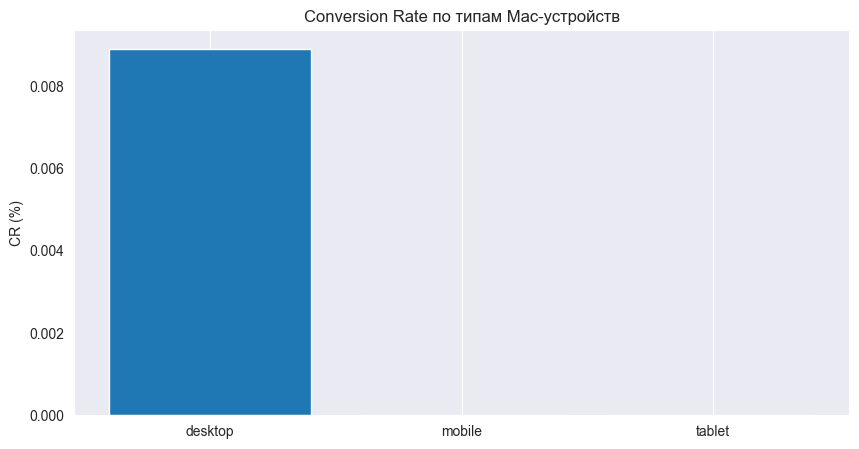

In [146]:
mac_data = data[data['device_os_grouped'] == 'Macintosh']
mac_device_category = mac_data.groupby("device_category").agg(
    total_sessions=('session_id', 'nunique'),
    conversions=('is_conversion', 'sum'),
    cr=('is_conversion', 'mean')
).reset_index()
display(mac_device_category)

# Визуализация
plt.figure(figsize=(10, 5))
plt.bar(mac_device_category['device_category'], mac_device_category['cr'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Conversion Rate по типам Mac-устройств')
plt.ylabel('CR (%)')
plt.grid(axis='y')
plt.show()

Странно, что есть телефоны и планшеты с ОС Макинтош. Возможно, это ошибка в данных. Но видно, что все конверсии были сделаны с компьютеров.

In [145]:
# Анализ страниц
page_analysis = mac_data.groupby('hit_page_path').agg(
    page_views=('hit_number', 'count'),
    conversions=('is_conversion', 'sum'),
    cr=('is_conversion', 'mean')
).reset_index()

# Фильтрация и сортировка
top_page_analysis = page_analysis[
    (page_analysis['page_views'] > 100) &  # Исключаем редко посещаемые
    (~page_analysis['hit_page_path'].str.contains('admin|test', na=False))  # Исключаем техстраницы
].sort_values('cr', ascending=False).head(3)
display(top_page_analysis)

,hit_page_path,page_views,conversions,cr
1746,podpiska.sberauto.com/faq,537,75,0.139665
1887,podpiska.sberauto.com/greenday,482,41,0.085062
4609,sberauto.com/cars/all/mercedes-benz/cla-klasse...,903,58,0.064230


По таблице виден топ-3 страницы по целевым действиям.

podpiska.sberauto.com/faq - страница с ответами на частые вопросы, высокий CR может означать, что пользователи находят здесь ключевую информацию, которая стимулирует их к действию.

podpiska.sberauto.com/greenday - возможно, страница с акциями, тогда высокий CR говорит о том, что таргетированные промо-кампании для Mac-аудитории работают.

sberauto.com/cars/all/mercedes-benz/cla-klasse... - страница определённой модели машины. Пользователи Mac чаще конвертируются на страницах с детальными описаниями и фото.

**Вывод:**

Гипотеза 1 (пункт 1) подтверждена:

- Mac-десктопы — ключевой сегмент с высокой конверсией благодаря удобству интерфейса.

- Страницы с детальной информацией (FAQ, каталог) играют решающую роль в принятии решения.